In [6]:
from ortools.sat.python import cp_model
import numpy as np
import matplotlib.pyplot as plt
import itertools

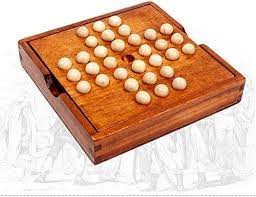

The goal of Peg Solitaire is to remove all pegs from the board except one, typically aiming to leave the last peg in the center hole. 

The player removes pegs by jumping one peg over another into an empty hole. The peg that has been jumped over is then removed from the board. A valid move involves a peg jumping horizontally or vertically over an adjacent peg into an empty hole on the other side.

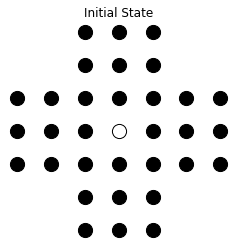

In [111]:
# Initial grid, -2 and 2 are used as placeholders for areas that aren't used
grid = [[-2, 2, 1, 1, 1, -2, 2],
       [-2, 2, 1, 1, 1, -2, 2],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [-2, 2, 1, 1, 1, -2, 2],
       [-2, 2, 1, 1, 1, -2, 2]]

# Plotting
size = 200
plt.figure(figsize=(4,4))
for i,j in list(itertools.product(range(7),range(7))):
    if grid[i][j] not in [-2,2]:
        if grid[i][j] == 1:
            plt.scatter(j,6-i, marker = 'o', c = 'k', s = size)
        else:
            plt.scatter(j,6-i, marker = 'o', c = 'w', s = size, edgecolors='k')
plt.title('Initial State')
plt.axis('off')
plt.show()

In [100]:
# Creates the model and set solver
model = cp_model.CpModel()
solver = cp_model.CpSolver()

# Size of the grid
n = range(7)
# Number of stages
S = range(7**2)

# Cell variables at each stage
x = {(i,j,s): model.NewIntVar(-2 , 2, f'x_{i}_{j}_{s}') for i in n for j in n for s in S}

# Variables for pin direction (1 == pin moves in that direction, 0 otherwise)
up = {(i,j,s): model.NewBoolVar(f'up_{i}_{j}_{s}') for i in n for j in n for s in S}
down = {(i,j,s): model.NewBoolVar(f'down_{i}_{j}_{s}') for i in n for j in n for s in S}
left = {(i,j,s): model.NewBoolVar(f'left_{i}_{j}_{s}') for i in n for j in n for s in S}
right = {(i,j,s): model.NewBoolVar(f'right_{i}_{j}_{s}') for i in n for j in n for s in S}

# Termination variable (1 == terminate, 0 otherwise)
term = {(s): model.NewBoolVar(f'term_{s}') for s in S}

for i in n:
    for j in n:
        # Connecting the original grid to the variables
        model.Add(x[i,j,0] == grid[i][j])

# Must terminated once in the sequence
model.AddAtLeastOne([term[s] for s in S])

for s in S:
    # At most one choice per cell
    model.Add(sum(up[i,j,s] + down[i,j,s] + left[i,j,s] + right[i,j,s] for i in n for j in n) <= 1)

    # If terminated, then there is only one pin on the board
    model.Add(sum(x[i,j,s] for i in n for j in n) == 1).OnlyEnforceIf(term[s])
    # If not terminated, then there are other pins on the board
    model.Add(sum(x[i,j,s] for i in n for j in n) != 1).OnlyEnforceIf(term[s].Not())
    # Final stage has one pin in the middle
    model.Add(x[3,3,s] == 1).OnlyEnforceIf(term[s])

    if s > 0:
        if s != S:
            # Ensure that if terminated at this stage, then subsequent stages are terminated
            model.Add(term[s-1] <= term[s])
        for i in n:
            for j in n:

                expr_up = [up[i+a,j+b,s].Not() for (a,b) in [(1,0),(2,0),(0,0)] if (i+a) in range(len(grid)) and (j+b) in range(len(grid))]
                expr_down = [down[i+a,j+b,s].Not() for (a,b) in [(-1,0),(-2,0),(0,0)] if (i+a) in range(len(grid)) and (j+b) in range(len(grid))]
                expr_left = [left[i+a,j+b,s].Not() for (a,b) in [(0,1),(0,2),(0,0)] if (i+a) in range(len(grid)) and (j+b) in range(len(grid))]
                expr_right = [right[i+a,j+b,s].Not() for (a,b) in [(0,-1),(0,-2),(0,0)] if (i+a) in range(len(grid)) and (j+b) in range(len(grid))]
                
                expr = expr_up + expr_down + expr_left + expr_right

                # Cell stays the same if no choice made
                model.Add(x[i,j,s-1] == x[i,j,s]).OnlyEnforceIf(expr)

                if grid[i][j] in [-2,2]:
                    # Areas that aren't used in the grid
                    model.Add(up[i,j,s] + down[i,j,s] + left[i,j,s] + right[i,j,s] == 0)  
                    model.Add(x[i,j,s-1] == x[i,j,s])
                if grid[i][j] not in [-2,2]:
                    # Each usable cell should either equal 0 or 1
                    model.Add(0 <= x[i,j,s])
                    model.Add(x[i,j,s] <= 1)
                
                # Creating boundaries for each cell,direction combination
                if i < 2:
                    model.Add(up[i,j,s] == 0)
                if i+2 > len(grid)-1:
                    model.Add(down[i,j,s] == 0)
                if j < 2:
                    model.Add(left[i,j,s] == 0)
                if j+2 > len(grid)-1:
                    model.Add(right[i,j,s] == 0)   

                # Up
                if i >= 2: 
                    if grid[i-2][j] not in [-2,2]:
                        # If up, then this value is == 1
                        model.Add(x[i,j,s-1] == 1).OnlyEnforceIf(up[i,j,s])  
                        # If up, then the value 1 spot above == 1
                        model.Add(x[i-1,j,s-1] == 1).OnlyEnforceIf(up[i,j,s])                    
                        # If up, then the value 2 spots above == 0
                        model.Add(x[i-2,j,s-1] == 0).OnlyEnforceIf(up[i,j,s])

                        # If up, then this value == 0
                        model.Add(x[i,j,s] == 0).OnlyEnforceIf(up[i,j,s])
                        # If up, then the value 1 spot above == 0
                        model.Add(x[i-1,j,s] == 0).OnlyEnforceIf(up[i,j,s])
                        # If up, then the value 2 spots above == 1
                        model.Add(x[i-2,j,s] == 1).OnlyEnforceIf(up[i,j,s])
                    else:
                        # If the final location is in [-2,2], the this direction is not permitted
                        model.Add(up[i,j,s] == 0)

                # Down
                if i <= 4:
                    if grid[i+2][j] not in [-2,2]:
                        # If down, then this value is == 1
                        model.Add(x[i,j,s-1] == 1).OnlyEnforceIf(down[i,j,s])  
                        # If down, then the value 1 spot above == 1
                        model.Add(x[i+1,j,s-1] == 1).OnlyEnforceIf(down[i,j,s])                    
                        # If down, then the value 2 spots above == 0
                        model.Add(x[i+2,j,s-1] == 0).OnlyEnforceIf(down[i,j,s])

                        # If down, then this value == 0
                        model.Add(x[i,j,s] == 0).OnlyEnforceIf(down[i,j,s])
                        # If down, then the value 1 spot above == 0
                        model.Add(x[i+1,j,s] == 0).OnlyEnforceIf(down[i,j,s])
                        # If down, then the value 2 spots above == 1
                        model.Add(x[i+2,j,s] == 1).OnlyEnforceIf(down[i,j,s])
                    else:
                        # If the final location is in [-2,2], the this direction is not permitted
                        model.Add(down[i,j,s] == 0)

                # Left
                if j >= 2:
                    if grid[i][j-2] not in [-2,2]:
                        # If left, then this value is == 1
                        model.Add(x[i,j,s-1] == 1).OnlyEnforceIf(left[i,j,s])  
                        # If left, then the value 1 spot left == 1
                        model.Add(x[i,j-1,s-1] == 1).OnlyEnforceIf(left[i,j,s])                    
                        # If left, then the value 2 spots left == 0
                        model.Add(x[i,j-2,s-1] == 0).OnlyEnforceIf(left[i,j,s])

                        # If left, then this value == 0
                        model.Add(x[i,j,s] == 0).OnlyEnforceIf(left[i,j,s])
                        # If left, then the value 1 spot left == 0
                        model.Add(x[i,j-1,s] == 0).OnlyEnforceIf(left[i,j,s])
                        # If left, then the value 2 spots left == 1
                        model.Add(x[i,j-2,s] == 1).OnlyEnforceIf(left[i,j,s])  
                    elif grid[i][j-2] in [-2,2]:
                        # If the final location is in [-2,2], the this direction is not permitted
                        model.Add(left[i,j,s] == 0)

                # Right
                if j <= 4:
                    if grid[i][j+2] not in [-2,2]:
                        # If right, then this value is == 1
                        model.Add(x[i,j,s-1] == 1).OnlyEnforceIf(right[i,j,s])  
                        # If right, then the value 1 spot right == 1
                        model.Add(x[i,j+1,s-1] == 1).OnlyEnforceIf(right[i,j,s])                    
                        # If right, then the value 2 spots right == 0
                        model.Add(x[i,j+2,s-1] == 0).OnlyEnforceIf(right[i,j,s])

                        # If right, then this value == 0
                        model.Add(x[i,j,s] == 0).OnlyEnforceIf(right[i,j,s])
                        # If right, then the value 1 spot right == 0
                        model.Add(x[i,j+1,s] == 0).OnlyEnforceIf(right[i,j,s])
                        # If right, then the value 2 spots right == 1
                        model.Add(x[i,j+2,s] == 1).OnlyEnforceIf(right[i,j,s])
                    else:
                        # If the final location is in [-2,2], the this direction is not permitted
                        model.Add(right[i,j,s] == 0)
# Solving
status = solver.Solve(model)
print(f"Status = {solver.StatusName(status)}")

# Storing Solution
sol = [solver.value(x[i,j,s]) for s in S for i in n for j in n]
sol = np.reshape(sol, (len(S),7,7))

Status = OPTIMAL


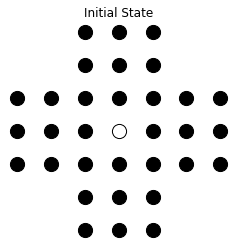

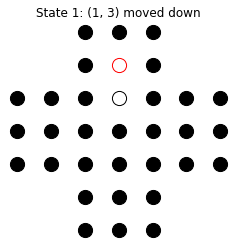

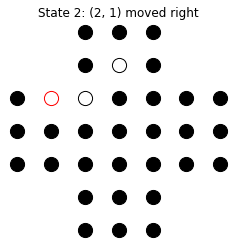

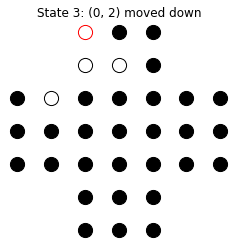

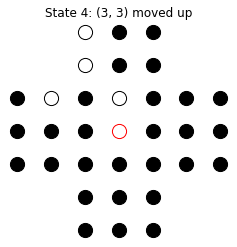

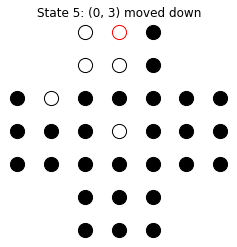

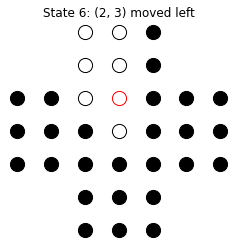

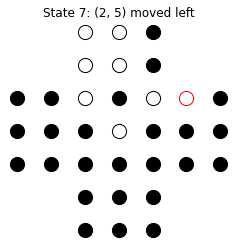

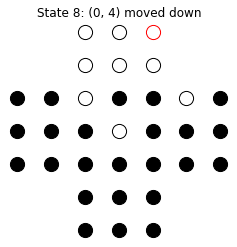

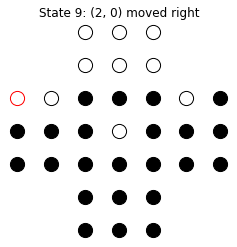

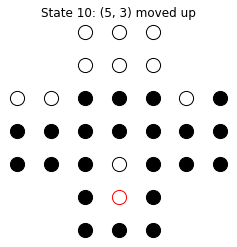

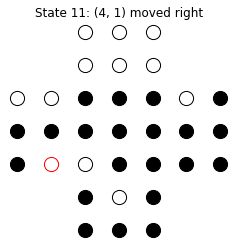

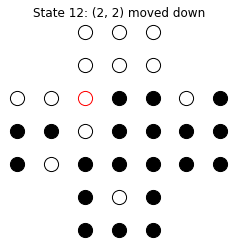

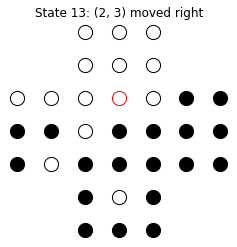

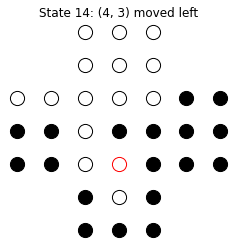

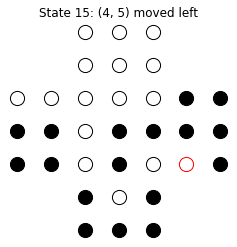

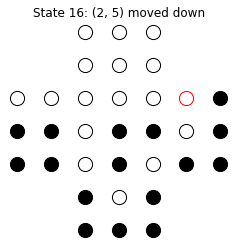

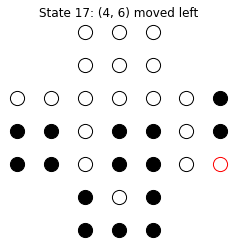

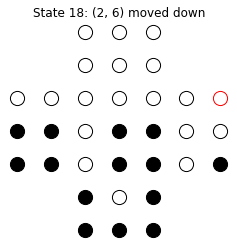

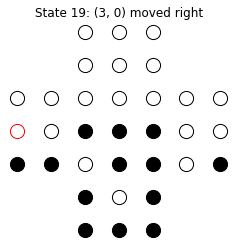

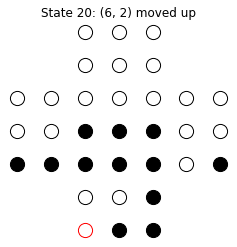

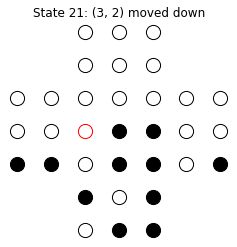

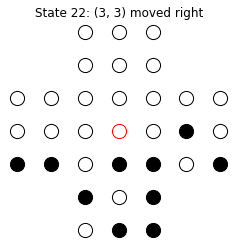

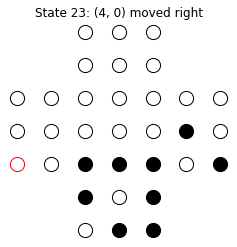

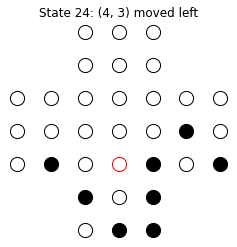

<Figure size 288x288 with 0 Axes>

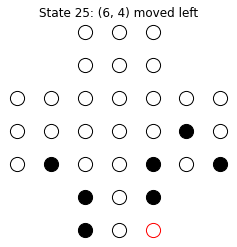

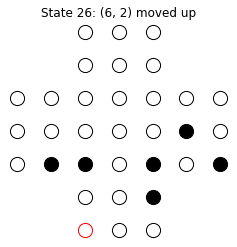

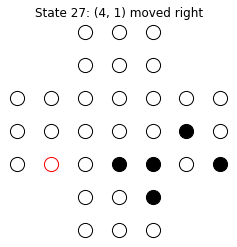

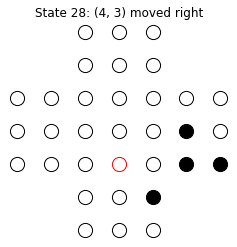

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

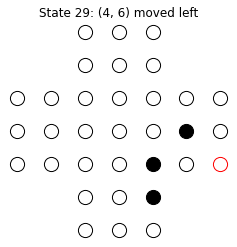

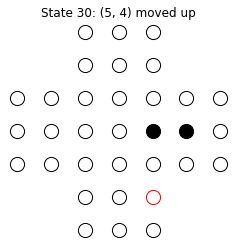

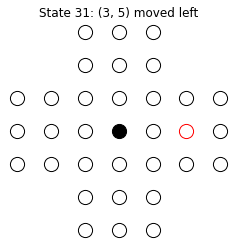

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [114]:
size = 200
count = 0
moves = []

# Plotting
for s in S:
    plt.figure(figsize= (4,4))

    moves.append([[f'{(i,j)} moved up' for i in n for j in n if solver.value(up[i,j,s]) == 1], 
                     [f'{(i,j)} moved down' for i in n for j in n if solver.value(down[i,j,s]) == 1],
                      [f'{(i,j)} moved left' for i in n for j in n if solver.value(left[i,j,s]) == 1],
                      [f'{(i,j)} moved right' for i in n for j in n if solver.value(right[i,j,s]) == 1]])
    
    for i,j in list(itertools.product(range(7),range(7))):

        if solver.value(up[i,j,s]) + solver.value(down[i,j,s]) + \
               solver.value(left[i,j,s]) + solver.value(right[i,j,s]) == 0:
            ec = 'k'
        else:
            ec = 'r'

        if s == 0:
            if sol[s,i,j] not in [-2,2]:
                plt.title('Initial State');
                if sol[s,i,j] == 1:
                    plt.scatter(j,6-i, marker = 'o', s = size, c = 'k');
                else:
                    plt.scatter(j,6-i, marker = 'o', s = size, c = 'w', edgecolors= ec);

        elif not np.array_equal(sol[s-1],sol[s]) and sol[s,i,j] not in [-2,2]:
            plt.title(f'State {count}: {"".join([i[0] for i in moves[s] if i != []])}');
            if sol[s,i,j] == 1:
                plt.scatter(j,6-i, marker = 'o', s = size, c = 'k');
            else:
                plt.scatter(j,6-i, marker = 'o', s = size, c = 'w', edgecolors= ec);
    
    if np.array_equal(sol[s-1],sol[s]):
        continue
    else:
        count+=1
        plt.axis('off');
        plt.show();